In [152]:
import os
from collections import Counter
from pathlib import Path
import re

import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.impute import SimpleImputer
import mgitools.os_helpers as os_helpers
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import seaborn as sns


In [26]:
# !pip install git+https://github.com/estorrs/mgitools
# !pip install sklearn
# !conda install -y -c bioconda scanpy

In [126]:
results_dir = '/data/results/09232020_data_prep'
Path(results_dir).mkdir(exist_ok=True, parents=True)

###### name conversion

In [6]:
CANCER_TYPE_MAP = {
    'CPTAC2_BRCA_prospective': 'BRCA_prospective',
    'TCGA_BRCA_retrospective': 'BRCA_retrospective',
    'BR': 'BRCA_prospective',
    'BRCA': 'BRCA_prospective',
    'CPTAC2_CRC_prospective': 'CRC_prospective',
    'CO': 'CRC_prospective',
    'COADREAD': 'CRC_prospective',
    'CPTAC2_OV_prospective': 'OV_prospective',
    'TCGA_OV_retrospective': 'OV_retrospective',
    'OV': 'OV_prospective',
    'CPTAC3_CCRCC_discovery': 'CCRCC',
    'KIRC': 'CCRCC',
    'CPTAC3_GBM_discovery': 'GBM',
    'CPTAC3_HNSCC_discovery': 'HNSCC',
    'HNSC': 'HNSCC',
    'CPTAC3_LSCC_discovery': 'LSCC',
    'LUSC': 'LSCC',
    'CPTAC3_LUAD_discovery': 'LUAD',
    'CPTAC3_UCEC_discovery': 'UCEC'
}

# data processing

### driver genes

In [402]:
genes = pd.read_csv('/data/driver_genes/bailey_smg_table.tsv', sep='\t')
genes['Cancer'] = [CANCER_TYPE_MAP.get(c, c) for c in genes['Cancer']]
genes

,Gene,Cancer
0,ABL1,PANCAN
1,ACVR1,UCEC
2,ACVR1B,PANCAN
3,ACVR2A,CRC_prospective
4,ACVR2A,LIHC
...,...,...
734,ZMYM3,PRAD
735,ZNF133,OV_prospective
736,ZNF750,PANCAN
737,ZNF750,ESCA


In [8]:
drivers = pd.read_csv('/data/driver_genes/199_driver_list.txt', sep='\t')
drivers

,Gene,Tumor suppressor or oncogene prediction (by 20/20+)
0,PHF6,possible tsg
1,ABL1,NaN
2,ALK,NaN
3,AR,NaN
4,ARAF,NaN
...,...,...
183,KMT2A,tsg
184,KMT2B,tsg
185,MAX,oncogene
186,MED12,oncogene


In [439]:
drivers[drivers['Gene']=='KMT2D']

,Gene,Status
105,KMT2D,tsg


In [403]:
cancer_to_driver_genes = {CANCER_TYPE_MAP.get(c, c):genes[genes['Cancer']==c].set_index('Gene')
                          for c in sorted(set(genes['Cancer']))}
cancer_to_driver_genes.keys()

dict_keys(['ACC', 'BLCA', 'BRCA_prospective', 'CCRCC', 'CESC', 'CHOL', 'CRC_prospective', 'DLBC', 'ESCA', 'GBM', 'HNSCC', 'KICH', 'KIRP', 'LAML', 'LGG', 'LIHC', 'LSCC', 'LUAD', 'MESO', 'OV_prospective', 'PAAD', 'PANCAN', 'PCPG', 'PRAD', 'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM'])

### somatic mutations

In [10]:
mutation_dir = '/data/somtatic_mutations/'
mutation_fps = sorted(os_helpers.listfiles(mutation_dir, regex=r'.maf$'))
mutation_fps

['/data/somtatic_mutations/BR.maf',
 '/data/somtatic_mutations/CCRCC.maf',
 '/data/somtatic_mutations/CO.maf',
 '/data/somtatic_mutations/GBM.maf',
 '/data/somtatic_mutations/HNSCC.maf',
 '/data/somtatic_mutations/LSCC.maf',
 '/data/somtatic_mutations/LUAD.maf',
 '/data/somtatic_mutations/OV.maf',
 '/data/somtatic_mutations/UCEC.maf']

In [11]:
cancer_to_maf = {}
for fp in mutation_fps:
    cancer = fp.split('/')[-1].split('.')[0]
    mutation_df = pd.read_csv(fp, sep='\t')
    mutation_df['sample_id'] = [x.split('_')[0] for x in mutation_df['Tumor_Sample_Barcode']]
    mutation_df = mutation_df[mutation_df['Variant_Classification']!='Silent']
    cancer_to_maf[CANCER_TYPE_MAP.get(cancer, cancer)] = mutation_df
cancer_to_maf.keys()

/miniconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (88) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


dict_keys(['BRCA_prospective', 'CCRCC', 'CRC_prospective', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'OV_prospective', 'UCEC'])

### gene expression

In [12]:
expression_dir = '/data/expression'
expression_fps = sorted(os_helpers.listfiles(expression_dir, regex=r'fpkm.tsv$'))
expression_fps

['/data/expression/AML_fpkm.tsv',
 '/data/expression/BR_fpkm.tsv',
 '/data/expression/CCRCC_fpkm.tsv',
 '/data/expression/CM_fpkm.tsv',
 '/data/expression/CO_fpkm.tsv',
 '/data/expression/EGAD-PDAC_fpkm.tsv',
 '/data/expression/GBM_fpkm.tsv',
 '/data/expression/HNSCC_fpkm.tsv',
 '/data/expression/LSCC_fpkm.tsv',
 '/data/expression/LUAD_fpkm.tsv',
 '/data/expression/OV_fpkm.tsv',
 '/data/expression/PDA_fpkm.tsv',
 '/data/expression/SAR_fpkm.tsv',
 '/data/expression/UCEC_fpkm.tsv',
 '/data/expression/eocg_fpkm.tsv',
 '/data/expression/hipsci_managed_fpkm.tsv',
 '/data/expression/hipsci_public_fpkm.tsv']

In [249]:
cancer_type_to_expression = {}
for fp in expression_fps:
    cancer = fp.split('/')[-1].replace('_fpkm.tsv', '')

    cancer_type_to_expression[CANCER_TYPE_MAP.get(cancer, cancer)] = pd.read_csv(fp, sep='\t', index_col='gene')
cancer_type_to_expression.keys()

dict_keys(['AML', 'BRCA_prospective', 'CCRCC', 'CM', 'CRC_prospective', 'EGAD-PDAC', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'OV_prospective', 'PDA', 'SAR', 'UCEC', 'eocg', 'hipsci_managed', 'hipsci_public'])

In [251]:
def update_rnaseq_identifiers(df, cancer):   
    if cancer in ['BRCA_prospective', 'CCRCC', 'CRC_prospective', 'GBM',
                  'HNSCC', 'LSCC', 'LUAD', 'OV_prospective','UCEC']:
        df.columns = [x.split('.')[0] + '.' + x.split('.')[2] for x in df.columns]
        df.columns = [re.sub(r'\.A$', r'.N', x) for x in df.columns]

    return df


In [253]:
cancer_type_to_expression = {c:update_rnaseq_identifiers(df, c) for c, df in cancer_type_to_expression.items()}

In [254]:
cancer_type_to_expression['OV_prospective']

,04OV063.T,04OV008.T,17OV017.T,04OV031.T,17OV033.T,04OV045.T,01OV002.T,04OV041.T,04OV005.T,04OV053.T,...,01OV023.T,26OV009.T,01OV007.T,01OV041.T,04OV018.T,02OV008.T,02OV041.T,11OV009.T,02OV044.T,26OV011.T
gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.032443,0.021776,0.123234,0.045337,0.000000,0.087575,0.000000,0.040048,0.102580,0.011262,...,0.009887,0.177850,0.016796,0.057254,0.126697,0.049117,0.021752,0.012676,0.000000,0.062966
A1BG-AS1,2.683421,1.108771,1.908946,1.609401,0.420666,2.456358,0.449302,1.852457,1.078961,0.403827,...,0.638153,1.163849,1.084081,1.163364,1.559776,0.732663,0.062398,0.327249,0.635105,1.023533
A1CF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010052,0.000000,0.000000,0.000000,...,0.004125,0.000000,0.000000,0.000000,0.000000,0.000000,0.004537,0.000000,0.000000,0.000000
A2M,37.153937,146.004446,205.628152,79.835018,28.689972,116.398757,39.329016,58.126210,109.807821,27.547028,...,51.377506,16.900725,66.320905,147.104826,123.017889,92.845618,9.152065,32.921428,35.108583,86.615568
A2M-AS1,1.838044,2.487276,14.076032,0.434989,0.496299,0.835809,1.086264,1.006355,1.812223,3.169611,...,0.993814,1.807983,1.427357,0.906840,2.257571,2.369764,0.755312,3.219959,2.242263,1.016481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYXP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ZZEF1,1.560680,4.060066,4.362171,2.550757,2.422705,2.027843,1.996111,1.106388,2.038841,1.062678,...,1.833474,2.647409,1.241629,3.459622,2.988774,4.790796,0.367699,3.501825,0.288603,2.311439
ZZZ3,10.219841,7.664908,15.564341,7.943791,10.579370,9.018188,12.616435,9.078584,7.582914,5.263809,...,10.913311,6.465828,10.759819,8.028981,8.061910,7.623224,11.124555,17.502873,10.215187,8.638574


### protein

In [71]:
def process_gct(fp):
    f = open(fp)
    f.readline()
    _, n_samples, n_feature_metadata, n_sample_metadata = [int(x) for x in f.readline().strip().split('\t')]
    df = pd.read_csv(f, sep='\t')
    df.columns = [c[1:] if c[0]=='X' else c for c in df.columns]

    ## do some renaming and split metadata into different table
    ids = df['id'].to_list()[:n_sample_metadata - 1]
    metadata = df.iloc[:n_sample_metadata - 1, -n_samples:].copy()
    metadata.index = ids
    metadata = metadata.transpose()


    df = df.iloc[n_sample_metadata:, :]
    #     print(df.shape)
    df = df.set_index('id')
    df.index.name = 'site_id'
    
    ## pull out samples we have metadata for
    data = df[[c for c in metadata.index if c in df.columns]]
    
    ## pull out variable data
    var = df[[c for c in df.columns if c not in metadata.index]]
    
    adata = anndata.AnnData(X=data.values.transpose(), obs=metadata, var=var)
    adata.obs.index.name = 'sample_id'
    
    ## add gene name in
    adata.var['gene'] = [x.split(':')[0] for x in adata.var.index]
    
    return adata

In [331]:
def update_identifiers(adata, cancer):
    if cancer in ['LUAD', 'LSCC']:
        adata.obs.index = [x + '.T' if x[-2:]!='.N' else x for x in adata.obs.index]
        
    if cancer in ['CCRCC', 'UCEC']:
        adata.obs.index = [x + '.T' if 'Tumor' in y else x + '.N'
                          for x, y in zip(adata.obs['case_id'], adata.obs['sample_type'])]
    
    if cancer in ['GBM', 'BRCA_prospective']:
        adata.obs.index = [x + '.T' for x in adata.obs.index]
        
    if cancer in ['OV_prospective']:
        adata.obs.index = [re.sub(r'^C(.*)$', r'\1', x) + '.T' if y == 'Primary Tumor' else re.sub(r'^C(.*)$', r'\1', x) + '.N'
                          for x, y in zip(adata.obs.index, adata.obs['sample_type'])]
        
    if cancer in ['CRC_prospective', 'HNSCC']:
        adata.obs.index = [x.replace('-', '.') for x in adata.obs.index]
        
    adata.obs['sample_type'] = ['tumor' if x[-2:]=='.T' else 'normal' for x in adata.obs.index]
    return adata


In [332]:
def impute_highly_missing(adata, threshold=.75):
    counts = np.count_nonzero(~np.isnan(adata.X), axis=0)
    frac_present = counts / adata.shape[0]
    mask = [True if x >= threshold else False for x in frac_present]
    new_adata = adata[:, mask].copy()

    new_adata = anndata.AnnData(X=SimpleImputer(strategy='median').fit_transform(new_adata.X),
                               obs=new_adata.obs, var=new_adata.var)

    
    return new_adata

In [333]:
def aggregate_to_gene_level(adata):
    df = pd.DataFrame(data=adata.X.transpose(), columns=adata.obs.index)
    df['gene'] = adata.var['gene'].to_list()
    df = df.groupby('gene').mean()
    
    new_adata = anndata.AnnData(X=df.values.transpose(), obs=adata.obs,)
    new_adata.var.index = df.index
    
    return new_adata

#### acetyl

In [334]:
fps = sorted(os_helpers.listfiles('/data/v2.0/', regex=r'acetylome.*.gct'))
fps

['/data/v2.0/CPTAC2_BRCA_prospective/CPTAC2_BRCA_prospective_broad_acetylome.v2.0.gct',
 '/data/v2.0/CPTAC3_GBM_discovery/CPTAC3_GBM_discovery_pnnl_acetylome.v2.0.gct',
 '/data/v2.0/CPTAC3_LSCC_discovery/CPTAC3_LSCC_discovery_broad_acetylome.v2.0.gct',
 '/data/v2.0/CPTAC3_LUAD_discovery/CPTAC3_LUAD_discovery_broad_acetylome.v2.0.gct',
 '/data/v2.0/CPTAC3_UCEC_discovery/CPTAC3_UCEC_discovery_pnnl_acetylome.v2.0.gct']

In [335]:
cancer_to_adata = {}
for fp in fps:
    cancer = fp.split('/')[3]
    cancer = CANCER_TYPE_MAP.get(cancer, cancer)
    
    cancer_to_adata[cancer] = process_gct(fp)
    
cancer_to_adata.keys()

/miniconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (6,7,11,13,14,15,16,17,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/miniconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (6,7,11,13,14,15,16,17,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93

dict_keys(['BRCA_prospective', 'GBM', 'LSCC', 'LUAD', 'UCEC'])

In [337]:
cancer_to_adata = {c:update_identifiers(adata, c) for c, adata in cancer_to_adata.items()}

In [339]:
cancer_to_gene_level = {c:aggregate_to_gene_level(adata) for c, adata in cancer_to_adata.items()}

/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

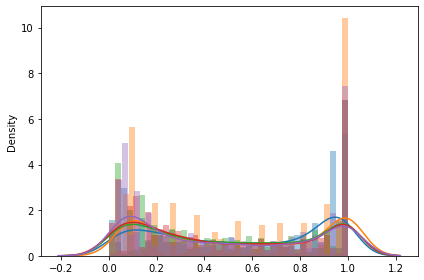

In [341]:
for cancer, adata in cancer_to_gene_level.items():
    counts = np.count_nonzero(~np.isnan(adata.X), axis=0)
    frac_present = counts / adata.shape[0]
    sns.distplot(frac_present, bins=40,)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'fraction_of_genes_missing_acetyl.pdf'))

In [342]:
cancer_to_gene_level = {c:impute_highly_missing(adata, threshold=.9) for c, adata in cancer_to_gene_level.items()}

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categori

In [343]:
for cancer, adata in cancer_to_gene_level.items():
    adata.write_h5ad(os.path.join(results_dir, f'acetyl_processed_{cancer}.h5ad'))

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'tmt_experiment' as categorical
... storing 'tmt_channel' as categorical
... storing 'sample_type' as categorical
... storing 'tmt_experiment' as categorical
... storing 'tmt_channel' as categorical
... storing 'sample_type' as categorical
... storing 'case_id' as categorical
... storing 'tmt_experiment' as categorical
... storing 'tmt_channel' as categorical
... storing 'sample_type' as categorical
... storing 'case_id' as categorical
... storing 'tmt_experiment' as categorical
... storing 'tmt_channel' as categorical
... storing 'sample_type' as categorical
... storing 'case_id' as categorical
... storing 'sample_type' as categorical
... storing 'tmt_experiment' as categorical
... storing 'tmt_channel' as categorical


##### phospho

In [344]:
fps = sorted(os_helpers.listfiles('/data/v2.0/', regex=r'phosph.*.gct'))
fps

['/data/v2.0/CPTAC2_BRCA_prospective/CPTAC2_BRCA_prospective_broad_phosphoproteome.v2.0.gct',
 '/data/v2.0/CPTAC2_CRC_prospective/CPTAC2_CRC_prospective_pnnl_phosphoproteome.v2.0.gct',
 '/data/v2.0/CPTAC2_OV_prospective/CPTAC2_OV_prospective_pnnl_phosphoproteome.v2.0.gct',
 '/data/v2.0/CPTAC3_CCRCC_discovery/CPTAC3_CCRCC_discovery_umich_phosphoproteome.v2.0.gct',
 '/data/v2.0/CPTAC3_GBM_discovery/CPTAC3_GBM_discovery_pnnl_phosphoproteome.v2.0.gct',
 '/data/v2.0/CPTAC3_HNSCC_discovery/CPTAC3_HNSCC_discovery_umich_phosphoproteome.v2.0.gct',
 '/data/v2.0/CPTAC3_LSCC_discovery/CPTAC3_LSCC_discovery_broad_phosphoproteome.v2.0.gct',
 '/data/v2.0/CPTAC3_LUAD_discovery/CPTAC3_LUAD_discovery_broad_phosphoproteome.v2.0.gct',
 '/data/v2.0/CPTAC3_UCEC_discovery/CPTAC3_UCEC_discovery_pnnl_phosphoproteome.v2.0.gct',
 '/data/v2.0/TCGA_BRCA_retrospective/TCGA_BRCA_retrospective_broad_phosphoproteome.v2.0.gct',
 '/data/v2.0/TCGA_OV_retrospective/TCGA_OV_retrospective_pnnl_phosphoproteome.v2.0.gct']

In [345]:
cancer_to_adata = {}
for fp in fps:
    cancer = fp.split('/')[3]
    cancer = CANCER_TYPE_MAP.get(cancer, cancer)
    
    cancer_to_adata[cancer] = process_gct(fp)
    
cancer_to_adata.keys()

/miniconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (6,7,11,13,14,15,16,17,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/miniconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (5,6,7,8,13,15,16,17,18,19,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,9

dict_keys(['BRCA_prospective', 'CRC_prospective', 'OV_prospective', 'CCRCC', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'UCEC', 'BRCA_retrospective', 'OV_retrospective'])

In [346]:
cancer_to_adata = {c:update_identifiers(adata, c) for c, adata in cancer_to_adata.items()}

In [347]:
cancer_to_gene_level = {c:aggregate_to_gene_level(adata) for c, adata in cancer_to_adata.items()}

/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

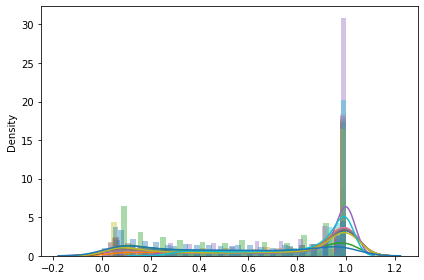

In [348]:
for cancer, adata in cancer_to_gene_level.items():
    counts = np.count_nonzero(~np.isnan(adata.X), axis=0)
    frac_present = counts / adata.shape[0]
    sns.distplot(frac_present, bins=40,)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'fraction_of_genes_missing_phospho.pdf'))

In [349]:
cancer_to_gene_level = {c:impute_highly_missing(adata, threshold=.9) for c, adata in cancer_to_gene_level.items()}

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categori

In [350]:
for cancer, adata in cancer_to_gene_level.items():
    adata.write_h5ad(os.path.join(results_dir, f'phospho_processed_{cancer}.h5ad'))

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'tmt_experiment' as categorical
... storing 'tmt_channel' as categorical
... storing 'sample_type' as categorical
... storing 'case_id' as categorical
... storing 'sample_type' as categorical
... storing 'tmt_experiment' as categorical
... storing 'case_id' as categorical
... storing 'sample_type' as categorical
... storing 'tmt_experiment' as categorical
... storing 'tmt_channel' as categorical
... storing 'case_id' as categorical
... storing 'sample_type' as categorical
... storing 'tmt_experiment' as categorical
... storing 'tmt_experiment' as categorical
... storing 'tmt_channel' as categorical
... storing 'sample_type' as categorical
... storing 'case_id' as categorical
... storing 'sample_type' as categorical
... storing 

##### proteome

In [351]:
fps = sorted(os_helpers.listfiles('/data/v2.0/', regex=r'_proteome.*.gct'))
fps

['/data/v2.0/CPTAC2_BRCA_prospective/CPTAC2_BRCA_prospective_broad_proteome.v2.0.gct',
 '/data/v2.0/CPTAC2_CRC_prospective/CPTAC2_CRC_prospective_pnnl_proteome.v2.0.gct',
 '/data/v2.0/CPTAC2_OV_prospective/CPTAC2_OV_prospective_pnnl_proteome.v2.0.gct',
 '/data/v2.0/CPTAC3_CCRCC_discovery/CPTAC3_CCRCC_discovery_umich_proteome.v2.0.gct',
 '/data/v2.0/CPTAC3_GBM_discovery/CPTAC3_GBM_discovery_pnnl_proteome.v2.0.gct',
 '/data/v2.0/CPTAC3_HNSCC_discovery/CPTAC3_HNSCC_discovery_umich_proteome.v2.0.gct',
 '/data/v2.0/CPTAC3_LSCC_discovery/CPTAC3_LSCC_discovery_broad_proteome.v2.0.gct',
 '/data/v2.0/CPTAC3_LUAD_discovery/CPTAC3_LUAD_discovery_broad_proteome.v2.0.gct',
 '/data/v2.0/CPTAC3_UCEC_discovery/CPTAC3_UCEC_discovery_pnnl_proteome.v2.0.gct',
 '/data/v2.0/TCGA_BRCA_retrospective/TCGA_BRCA_retrospective_broad_proteome.v2.0.gct',
 '/data/v2.0/TCGA_OV_retrospective/TCGA_OV_retrospective_pnnl_proteome.v2.0.gct']

In [352]:
cancer_to_adata = {}
for fp in fps:
    cancer = fp.split('/')[3]
    cancer = CANCER_TYPE_MAP.get(cancer, cancer)
    
    cancer_to_adata[cancer] = process_gct(fp)
    
cancer_to_adata.keys()

/miniconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (2,3,4,5,6,7,8,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/miniconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,

dict_keys(['BRCA_prospective', 'CRC_prospective', 'OV_prospective', 'CCRCC', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'UCEC', 'BRCA_retrospective', 'OV_retrospective'])

In [353]:
cancer_to_adata = {c:update_identifiers(adata, c) for c, adata in cancer_to_adata.items()}

In [354]:
for adata in cancer_to_adata.values(): adata.var.index.name = 'gene'
cancer_to_adata['CCRCC'].var

,num_psm,refseq_prot_ids,hgnc_id,entrez_gene_id,ensembl_gene_id,gene
gene,,,,,,
A1BG,1984,NP_570602.2,HGNC:5,1,ENSG00000121410,A1BG
A1CF,533,NP_620310.1,HGNC:24086,29974,ENSG00000148584,A1CF
A2M,8181,NP_000005.2,HGNC:7,2,ENSG00000175899,A2M
A4GALT,1,NP_001304967.1,HGNC:18149,53947,ENSG00000128274,A4GALT
AAAS,297,NP_056480.1,HGNC:13666,8086,ENSG00000094914,AAAS
...,...,...,...,...,...,...
ZXDC,26,NP_001035743.1,HGNC:28160,79364,ENSG00000070476,ZXDC
ZYG11B,167,NP_078922.1,HGNC:25820,79699,ENSG00000162378,ZYG11B
ZYX,1132,NP_001010972.1,HGNC:13200,7791,ENSG00000159840,ZYX


/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

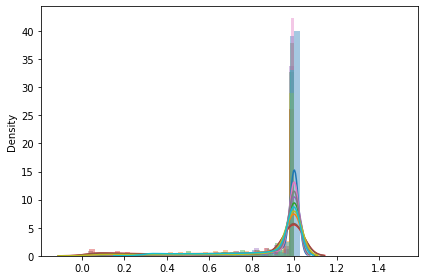

In [355]:
for cancer, adata in cancer_to_adata.items():
    counts = np.count_nonzero(~np.isnan(adata.X), axis=0)
    frac_present = counts / adata.shape[0]
    sns.distplot(frac_present, bins=40,)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'fraction_of_genes_missing_proteome.pdf'))

In [356]:
cancer_to_gene_level = {c:impute_highly_missing(adata, threshold=.9) for c, adata in cancer_to_gene_level.items()}

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categori

In [357]:
for cancer, adata in cancer_to_gene_level.items():
    adata.write_h5ad(os.path.join(results_dir, f'proteome_processed_{cancer}.h5ad'))

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


### dataset construction

In [409]:
def transform_gene_level_adata(adata, dtype):
    cases = adata.obs['case_id'].to_list()
    case_to_gene_to_vals = {}
    
    for case in cases:
        mini = adata[adata.obs['case_id']==case]
        case_to_gene_to_vals[case] = {}
        gene_to_index = {g:i for i, g in enumerate(mini.var.index)}
        for gene in sorted(adata.var.index):
            t_val, n_val = None, None
            for sample, case, stype, data in zip(mini.obs.index, mini.obs['case_id'], mini.obs['sample_type'],
                                            mini.X):
                if stype == 'tumor': t_val = data[gene_to_index[gene]]
                if stype == 'normal': n_val = data[gene_to_index[gene]]
         
            if t_val is not None and n_val is not None:
                tn_diff = t_val - n_val
                case_to_gene_to_vals[case][gene] = {
                    'tumor': t_val,
                    'normal': n_val,
                    'difference': t_val - n_val
                }
    
    idxs, data = [], []
    for case, d in case_to_gene_to_vals.items():
        for gene, vals in d.items():
            idxs.append(f'{gene}_{case}')
            data.append([vals['tumor'], vals['normal'], vals['difference']])
    df = pd.DataFrame(data=data, index=idxs,
                      columns=[f'{dtype}_tumor', f'{dtype}_normal', f'{dtype}_difference'])
    return df
            

In [410]:
fps = sorted(os_helpers.listfiles(results_dir, regex='acetyl.*.h5ad$'))
cancer_to_adata = {'_'.join(fp.split('/')[-1].split('_')[2:]).replace('.h5ad', ''):sc.read_h5ad(fp) for fp in fps}
cancer_to_adata.keys()

dict_keys(['BRCA_prospective', 'GBM', 'LSCC', 'LUAD', 'UCEC'])

In [411]:
acetyl_cancer_to_adata = {c:transform_gene_level_adata(adata, 'acetyl')
                         for c, adata in cancer_to_adata.items()}

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [412]:
fps = sorted(os_helpers.listfiles(results_dir, regex='phospho.*.h5ad$'))
cancer_to_adata = {'_'.join(fp.split('/')[-1].split('_')[2:]).replace('.h5ad', ''):sc.read_h5ad(fp) for fp in fps}
cancer_to_adata.keys()

dict_keys(['BRCA_prospective', 'BRCA_retrospective', 'CCRCC', 'CRC_prospective', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'OV_prospective', 'OV_retrospective', 'UCEC'])

In [413]:
phospho_cancer_to_adata = {c:transform_gene_level_adata(adata, 'phospho')
                         for c, adata in cancer_to_adata.items()}

In [414]:
# for c in cancer_to_adata.values(): print(c.obs.columns)

In [415]:
fps = sorted(os_helpers.listfiles(results_dir, regex='proteome.*.h5ad$'))
cancer_to_adata = {'_'.join(fp.split('/')[-1].split('_')[2:]).replace('.h5ad', ''):sc.read_h5ad(fp) for fp in fps}
cancer_to_adata.keys()

dict_keys(['BRCA_prospective', 'BRCA_retrospective', 'CCRCC', 'CRC_prospective', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'OV_prospective', 'OV_retrospective', 'UCEC'])

In [416]:
proteome_cancer_to_adata = {c:transform_gene_level_adata(adata, 'proteome')
                         for c, adata in cancer_to_adata.items()}

do the rnaseq stuff

In [417]:
def transform_rnaseq(df):
    counts = Counter([c.split('.')[0] for c in df.columns])
    cases = [s for s, c in counts.items() if c >= 2]
    data, idxs = [], []
    for case in cases:
        filtered = df[[c for c in df.columns if c.split('.')[0] in cases]]
        proceed = True if f'{case}.N' in filtered.columns and f'{case}.N' in filtered.columns else False
        if proceed:
            normal, tumor = filtered[f'{case}.N'], filtered[f'{case}.T']
            for n, t, gene in zip(normal, tumor, filtered.index):
                data.append([t, n, (t + 1) / (n + 1)])
                idxs.append(f'{gene}_{case}')
    new_df = pd.DataFrame(data=data, index=idxs,
                         columns=[f'rnaseq_tumor', f'rnaseq_normal', f'rnaseq_fc'])
    return new_df

In [418]:
# for c, df in cancer_type_to_expression.items():
#     if c in ['BRCA_prospective', 'BRCA_retrospective', 'CCRCC', 'CRC_prospective', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'OV_prospective', 'OV_retrospective', 'UCEC']:

#         print(c)
#         print(set([c.split('.')[-1] for c in df.columns]))

In [419]:
rnaseq_cancer_to_data = {c:transform_rnaseq(df) for c, df in cancer_type_to_expression.items()
                        if c in ['BRCA_prospective', 'BRCA_retrospective', 'CCRCC',
                                 'CRC_prospective', 'GBM', 'HNSCC', 'LSCC', 'LUAD',
                                 'OV_prospective', 'OV_retrospective', 'UCEC']}

create acetyl, phospho, proteome, rnaseq matrix

In [420]:
overlapping = set.intersection(set(acetyl_cancer_to_adata.keys()),
                              set(phospho_cancer_to_adata.keys()),
                              set(proteome_cancer_to_adata.keys()),
                              set(rnaseq_cancer_to_data.keys()))
overlapping

{'BRCA_prospective', 'GBM', 'LSCC', 'LUAD', 'UCEC'}

In [423]:
drivers = pd.read_csv('/data/driver_genes/199_driver_list.txt', sep='\t')
drivers

,Gene,Tumor suppressor or oncogene prediction (by 20/20+)
0,PHF6,possible tsg
1,ABL1,NaN
2,ALK,NaN
3,AR,NaN
4,ARAF,NaN
...,...,...
183,KMT2A,tsg
184,KMT2B,tsg
185,MAX,oncogene
186,MED12,oncogene


In [424]:
drivers.columns = ['Gene', 'Status']
driver_to_type = {}
for g, t in zip(drivers['Gene'], drivers['Status']):
    if not pd.isnull(t) and 'tsg' in t: driver_to_type[g] = 'tsg'
    if not pd.isnull(t) and 'oncogene' in t: driver_to_type[g] = 'oncogene'
driver_to_type

{'PHF6': 'tsg',
 'AXIN2': 'tsg',
 'CDKN2C': 'tsg',
 'CEBPA': 'oncogene',
 'MACF1': 'oncogene',
 'MSH3': 'oncogene',
 'PIK3CG': 'oncogene',
 'PMS1': 'oncogene',
 'PMS2': 'tsg',
 'PTPRC': 'oncogene',
 'SETBP1': 'oncogene',
 'SMC3': 'oncogene',
 'TBL1XR1': 'tsg',
 'CIC': 'tsg',
 'IDH1': 'oncogene',
 'BRAF': 'oncogene',
 'TP53': 'tsg',
 'BAP1': 'tsg',
 'CTNNB1': 'oncogene',
 'EGFR': 'oncogene',
 'KIT': 'oncogene',
 'KRAS': 'oncogene',
 'FOXA1': 'oncogene',
 'NOTCH1': 'tsg',
 'PIK3CA': 'oncogene',
 'SETD2': 'tsg',
 'EP300': 'tsg',
 'EPAS1': 'oncogene',
 'FBXW7': 'tsg',
 'ATRX': 'tsg',
 'GNAQ': 'oncogene',
 'HRAS': 'oncogene',
 'MTOR': 'oncogene',
 'PPP2R1A': 'oncogene',
 'RUNX1': 'tsg',
 'SF3B1': 'oncogene',
 'STK11': 'tsg',
 'VHL': 'tsg',
 'CDKN2A': 'tsg',
 'NFE2L2': 'oncogene',
 'NRAS': 'oncogene',
 'PTEN': 'tsg',
 'SMAD4': 'oncogene',
 'ERBB2': 'oncogene',
 'FUBP1': 'tsg',
 'MAP2K4': 'tsg',
 'NF1': 'tsg',
 'PBRM1': 'tsg',
 'PIK3R1': 'tsg',
 'RB1': 'tsg',
 'CASP8': 'tsg',
 'CDH1': 'tsg',


In [425]:
cancer_to_appr = {}
for cancer in overlapping:
    acetyl = acetyl_cancer_to_adata[cancer].copy()
    phospho = phospho_cancer_to_adata[cancer].copy()
    proteome = proteome_cancer_to_adata[cancer].copy()
    rnaseq = rnaseq_cancer_to_data[cancer].copy()
    
    ## merge
    df = pd.merge(acetyl, phospho, left_index=True, right_index=True)
    df = pd.merge(df, proteome, left_index=True, right_index=True)
    df = pd.merge(df, rnaseq, left_index=True, right_index=True)
    
    ds = genes[genes['Cancer']==cancer]['Gene'].to_list()
    df['is_driver'] = [True if g.split('_')[0] in ds else False for g in df.index]
    df['is_oncogene'] = [True if g.split('_')[0] in ds and driver_to_type.get(g.split('_')[0], '') == 'oncogene' else False
                   for g in df.index]
    df['is_tsg'] = [True if g.split('_')[0] in ds and driver_to_type.get(g.split('_')[0], '') == 'tsg' else False
                   for g in df.index]

    cancer_to_appr[cancer] = df

In [426]:
cancer_to_appr['UCEC']

,acetyl_tumor,acetyl_normal,acetyl_difference,phospho_tumor,phospho_normal,phospho_difference,proteome_tumor,proteome_normal,proteome_difference,rnaseq_tumor,rnaseq_normal,rnaseq_fc,is_driver,is_oncogene,is_tsg
ACIN1_C3L-01311,0.367800,-0.428750,0.796550,0.079959,-0.007581,0.087539,0.079959,-0.007581,0.087539,26.426126,24.367490,1.081153,False,False,False
ACLY_C3L-01311,0.175200,0.079000,0.096200,-1.263800,-0.417440,-0.846360,-1.263800,-0.417440,-0.846360,36.682894,25.806070,1.405760,False,False,False
ACTN1_C3L-01311,-0.366090,0.628590,-0.994680,-0.884500,0.497000,-1.381500,-0.884500,0.497000,-1.381500,19.638472,27.728370,0.718400,False,False,False
ACTN4_C3L-01311,-0.135107,0.120644,-0.255751,-0.336470,0.398000,-0.734470,-0.336470,0.398000,-0.734470,56.930365,52.157153,1.089794,False,False,False
ADH5_C3L-01311,0.108400,0.239250,-0.130850,0.191000,0.346000,-0.155000,0.191000,0.346000,-0.155000,49.071330,54.047941,0.909595,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF703_C3N-01346,-0.238410,0.481000,-0.719410,-0.787250,0.621000,-1.408250,-0.787250,0.621000,-1.408250,2.821011,3.655204,0.820804,False,False,False
ZNF740_C3N-01346,-0.403000,0.285000,-0.688000,-0.647500,-0.431500,-0.216000,-0.647500,-0.431500,-0.216000,12.748715,6.856613,1.749955,False,False,False
ZRANB2_C3N-01346,0.283000,-0.139650,0.422650,0.223357,-0.341436,0.564793,0.223357,-0.341436,0.564793,16.815139,25.180876,0.680464,False,False,False
ZSCAN18_C3N-01346,0.476000,0.336000,0.140000,-0.304143,0.818429,-1.122571,-0.304143,0.818429,-1.122571,10.677388,11.727478,0.917494,False,False,False


In [427]:
for cancer, df in cancer_to_appr.items(): print(cancer, df.shape)

LUAD (57469, 15)
UCEC (2268, 15)
BRCA_prospective (0, 15)
LSCC (57239, 15)
GBM (0, 15)


In [428]:
for cancer, df in cancer_to_appr.items(): print(cancer, df.shape, np.count_nonzero(df['is_driver']),
                                               np.count_nonzero(df['is_oncogene']),
                                               np.count_nonzero(df['is_tsg']))

LUAD (57469, 15) 202 0 202
UCEC (2268, 15) 48 6 30
BRCA_prospective (0, 15) 0 0 0
LSCC (57239, 15) 364 0 364
GBM (0, 15) 0 0 0


In [430]:
## aggregate
master = None
for cancer, df in cancer_to_appr.items():
    df['cancer_type'] = [cancer] * df.shape[0]
    if master is None:
        master = df
    else:
        master = pd.concat((master, df), axis=0)
master

,acetyl_tumor,acetyl_normal,acetyl_difference,phospho_tumor,phospho_normal,phospho_difference,proteome_tumor,proteome_normal,proteome_difference,rnaseq_tumor,rnaseq_normal,rnaseq_fc,is_driver,is_oncogene,is_tsg,cancer_type
ACIN1_C3N-01799,0.687550,0.188575,0.498975,0.151535,-0.209620,0.361155,0.151535,-0.209620,0.361155,24.947247,17.928953,1.370770,0.0,0.0,0.0,LUAD
ACLY_C3N-01799,0.397156,0.096444,0.300711,1.761150,0.269400,1.491750,1.761150,0.269400,1.491750,49.074934,23.936849,2.008070,0.0,0.0,0.0,LUAD
ACOX1_C3N-01799,-1.454800,-1.994000,0.539200,-1.228900,-2.360000,1.131100,-1.228900,-2.360000,1.131100,23.585992,16.541906,1.401558,0.0,0.0,0.0,LUAD
ACSL3_C3N-01799,0.066433,0.388700,-0.322267,-0.412300,-0.677500,0.265200,-0.412300,-0.677500,0.265200,15.517216,21.480543,0.734734,0.0,0.0,0.0,LUAD
ACTN1_C3N-01799,-0.381100,-0.080925,-0.300175,-0.684000,1.424622,-2.108622,-0.684000,1.424622,-2.108622,12.608740,10.549377,1.178309,0.0,0.0,0.0,LUAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF292_C3L-02349,0.376867,-0.785200,1.162067,-1.489850,-1.747625,0.257775,-1.489850,-1.747625,0.257775,9.175416,10.940414,0.852183,0.0,0.0,0.0,LSCC
ZNF407_C3L-02349,0.906000,1.422100,-0.516100,-0.685440,-0.272880,-0.412560,-0.685440,-0.272880,-0.412560,4.407454,6.955711,0.679695,0.0,0.0,0.0,LSCC
ZNF638_C3L-02349,1.133560,-2.044240,3.177800,0.254800,-0.324489,0.579289,0.254800,-0.324489,0.579289,30.060677,24.283453,1.228498,0.0,0.0,0.0,LSCC
ZNF740_C3L-02349,0.331800,-0.398233,0.730033,0.557900,0.836800,-0.278900,0.557900,0.836800,-0.278900,10.811067,6.972168,1.481538,0.0,0.0,0.0,LSCC


In [431]:
master.to_csv(os.path.join(results_dir, 'acetyl_phospho_proteome_rnaseq_processed.tsv'), sep='\t')

create phospho, proteome, rnaseq matrix

In [433]:
overlapping = set.intersection(set(rnaseq_cancer_to_data.keys()),
                              set(phospho_cancer_to_adata.keys()),
                              set(proteome_cancer_to_adata.keys()))
overlapping

{'BRCA_prospective',
 'CCRCC',
 'CRC_prospective',
 'GBM',
 'HNSCC',
 'LSCC',
 'LUAD',
 'OV_prospective',
 'UCEC'}

In [434]:
cancer_to_ppr = {}
for cancer in overlapping:
    phospho = phospho_cancer_to_adata[cancer].copy()
    proteome = proteome_cancer_to_adata[cancer].copy()
    rnaseq = rnaseq_cancer_to_data[cancer].copy()
    
    ## merge
    df = pd.merge(phospho, proteome, left_index=True, right_index=True)
    df = pd.merge(df, rnaseq, left_index=True, right_index=True)
    
    ds = genes[genes['Cancer']==cancer]['Gene'].to_list()
    df['is_driver'] = [True if g.split('_')[0] in ds else False for g in df.index]
    df['is_oncogene'] = [True if g.split('_')[0] in ds and driver_to_type.get(g.split('_')[0], '') == 'oncogene' else False
                   for g in df.index]
    df['is_tsg'] = [True if g.split('_')[0] in ds and driver_to_type.get(g.split('_')[0], '') == 'tsg' else False
                   for g in df.index]

    cancer_to_ppr[cancer] = df

In [435]:
for cancer, df in cancer_to_ppr.items(): print(cancer, df.shape, np.count_nonzero(df['is_driver']),
                                               np.count_nonzero(df['is_oncogene']),
                                               np.count_nonzero(df['is_tsg']))

HNSCC (77995, 12) 399 57 304
CCRCC (331500, 12) 525 75 450
LUAD (512171, 12) 1515 505 1010
UCEC (23346, 12) 228 54 96
BRCA_prospective (0, 12) 0 0 0
LSCC (487032, 12) 1183 91 1092
CRC_prospective (0, 12) 0 0 0
OV_prospective (0, 12) 0 0 0
GBM (0, 12) 0 0 0


In [436]:
## aggregate
master = None
for cancer, df in cancer_to_ppr.items():
    df['cancer_type'] = [cancer] * df.shape[0]
    if master is None:
        master = df
    else:
        master = pd.concat((master, df), axis=0)
master

,phospho_tumor,phospho_normal,phospho_difference,proteome_tumor,proteome_normal,proteome_difference,rnaseq_tumor,rnaseq_normal,rnaseq_fc,is_driver,is_oncogene,is_tsg,cancer_type
AAAS_C3L-00997,-0.117621,-0.266526,0.148905,-0.117621,-0.266526,0.148905,6.923990,8.393708,0.843542,0.0,0.0,0.0,HNSCC
AAGAB_C3L-00997,0.701370,0.215427,0.485943,0.701370,0.215427,0.485943,21.452536,13.562564,1.541798,0.0,0.0,0.0,HNSCC
AAK1_C3L-00997,0.095158,-0.207175,0.302333,0.095158,-0.207175,0.302333,5.187601,3.718107,1.311458,0.0,0.0,0.0,HNSCC
AAMDC_C3L-00997,0.431788,0.884505,-0.452717,0.431788,0.884505,-0.452717,1.718518,7.288834,0.327974,0.0,0.0,0.0,HNSCC
ABCA1_C3L-00997,0.571417,-0.862962,1.434379,0.571417,-0.862962,1.434379,40.232205,18.149402,2.153185,0.0,0.0,0.0,HNSCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN29_C3L-02349,-0.224700,-0.841750,0.617050,-0.224700,-0.841750,0.617050,6.930389,5.839625,1.159477,0.0,0.0,0.0,LSCC
ZSWIM8_C3L-02349,-0.611022,-0.123422,-0.487600,-0.611022,-0.123422,-0.487600,5.822905,13.501457,0.470498,0.0,0.0,0.0,LSCC
ZYX_C3L-02349,-0.478874,2.737958,-3.216832,-0.478874,2.737958,-3.216832,15.860712,34.997164,0.468390,0.0,0.0,0.0,LSCC
ZZEF1_C3L-02349,0.719029,0.970279,-0.251250,0.719029,0.970279,-0.251250,11.512381,13.230414,0.879270,0.0,0.0,0.0,LSCC


In [437]:
master.to_csv(os.path.join(results_dir, 'phospho_proteome_rnaseq_processed.tsv'), sep='\t')